In [2]:
import jax
jax.config.update('jax_enable_x64',True)
import jax.numpy as jnp
import pandas as pd
from jax.random import PRNGKey as pkey
from jax.scipy.special import expit
from jaxopt import LBFGS
import statsmodels.api as sm


In [168]:
beta_true = 1.
num_covs = 1
num_subjects_per_group = 2000
num_groups = 4
total_subjects = num_subjects_per_group*num_groups
num_exposures = num_groups -1 
intercept_val = 0.2
confounding_constant = 0.2
assignment = jnp.vstack([jnp.arange(num_groups)]*num_subjects_per_group).T.flatten().reshape(-1,1)
covs = jnp.hstack([jax.random.normal(pkey(12),(total_subjects,num_covs))]) + confounding_constant*assignment
beta_covs = jax.random.normal(pkey(13),(num_covs,))
full_beta = jnp.hstack([beta_true,intercept_val,beta_covs])


#This is just for simulating
X_sim = jnp.hstack([assignment,jnp.ones((total_subjects,1)),covs])
Y_obs = jax.random.binomial(pkey(1),1,expit(X_sim@full_beta))

dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

model = sm.Logit(Y_obs, df_reg)
results = model.fit()
results.summary()

L = results.params[-num_exposures:].values
V = jnp.diag(results.cov_params().values[-num_exposures:,-num_exposures:])

Optimization terminated successfully.
         Current function value: 0.427477
         Iterations 7


In [175]:
beta_true = 0.5
gamma_true = 1.
num_studies = 20
num_covs = 1
num_subjects_per_group = 5000
num_groups = 4
total_subjects = num_subjects_per_group*num_groups
num_exposures = num_groups -1 
intercept_val = 0.1
confounding_constant = 0.1

def simulate_study(key):
    keys = jax.random.split(key,10)

    assignment = jnp.vstack([jnp.arange(num_groups)]*num_subjects_per_group).T.flatten().reshape(-1,1)
    covs = jnp.hstack([jax.random.normal(keys[0],(total_subjects,num_covs))]) + confounding_constant*assignment
    beta_covs = jax.random.normal(keys[2],(num_covs,))

    beta_perturb = jnp.sqrt(gamma_true)*jax.random.normal(keys[8])

    beta_study = beta_true+beta_perturb
    full_beta = jnp.hstack([beta_study,intercept_val,beta_covs])

    #This is just for simulating
    X_sim = jnp.hstack([assignment,jnp.ones((total_subjects,1)),covs])
    Y_obs = jax.random.binomial(keys[5],1,expit(X_sim@full_beta))

    dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
    X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

    df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

    dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
    X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

    df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

    model = sm.Logit(Y_obs, df_reg)
    results = model.fit()
    results.summary()

    summary_df = pd.DataFrame({
        'assign':assignment[:,0],
        'is_case':Y_obs
    })
    total_non_cases = len(summary_df[summary_df['is_case']==0])
    reference_non_cases = len(summary_df[(summary_df['assign']==0)&(summary_df['is_case']==0)])
    p = reference_non_cases/total_non_cases
    total_cases = summary_df['is_case'].sum()
    z = total_non_cases/total_cases

    L = results.params[-num_exposures:].values
    V = jnp.diag(results.cov_params().values[-num_exposures:,-num_exposures:])
    return L,V,results,p,z

In [176]:
simulation_results = [
    simulate_study(pkey(10*i)) for i in range(num_studies)
]

Optimization terminated successfully.
         Current function value: 0.524351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303619
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.642231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.301253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.325830
  

In [177]:
L_vals = [res[0] for res in simulation_results]
V_vals = [res[1] for res in simulation_results]
reg_vals = [res[2] for res in simulation_results]
p_vals = [res[3] for res in simulation_results]
z_vals = [res[4] for res in simulation_results]

cov_mats = [result.cov_params().values[-num_exposures:,-num_exposures:] for result in reg_vals]
z = jnp.arange(1.,1+num_exposures)
x = jnp.arange(1.,1+num_exposures)
fake_cov_mats = [jnp.diag(jnp.diag(C)) for C in cov_mats]

Zmat = jnp.outer(z,z)

In [179]:
def margin_like(gamma):
    vmats = jnp.array([Zmat*gamma + C for C in cov_mats])
    LNV = jnp.sum(jnp.array([jnp.linalg.slogdet(V)[1] for V in vmats]))
    beta = (
        (1/jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@x for V in vmats]))) * 
        (1/jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@L for V,L in zip(vmats,L_vals)])))
    )
    res_term = jnp.sum(jnp.array([(x*beta - L).T@jnp.linalg.inv(V)@(x*beta-L) for V,L in zip(vmats,L_vals)]))
    return LNV+res_term

def margin_like_fake(gamma):
    vmats = jnp.array([Zmat*gamma + C for C in fake_cov_mats])
    LNV = jnp.sum(jnp.array([jnp.linalg.slogdet(V)[1] for V in vmats]))
    beta = (
        (1/jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@x for V in vmats]))) * 
        (1/jnp.sum(jnp.array([x.T@jnp.linalg.inv(V)@L for V,L in zip(vmats,L_vals)])))
    )
    res_term = jnp.sum(jnp.array([(x*beta - L).T@jnp.linalg.inv(V)@(x*beta-L) for V,L in zip(vmats,L_vals)]))
    return LNV+res_term

In [180]:
gamma_grid = jnp.logspace(-1,1.2,100)
loss_vals_cov = jax.jit(jax.vmap(margin_like))(gamma_grid)
loss_vals_diag = jax.jit(jax.vmap(margin_like_fake))(gamma_grid)

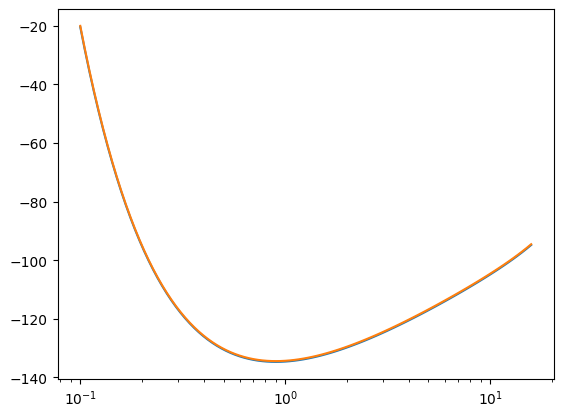

In [181]:
plt.plot(gamma_grid,loss_vals_cov)
plt.plot(gamma_grid,loss_vals_diag)
plt.xscale('log')

In [182]:
gamma_grid[jnp.argmin(loss_vals_diag)]

Array(0.90272518, dtype=float64)

In [183]:
gamma_grid[jnp.argmin(loss_vals_cov)]

Array(0.90272518, dtype=float64)

ValueError: x and y must have same first dimension, but have shapes (100,) and (40,)

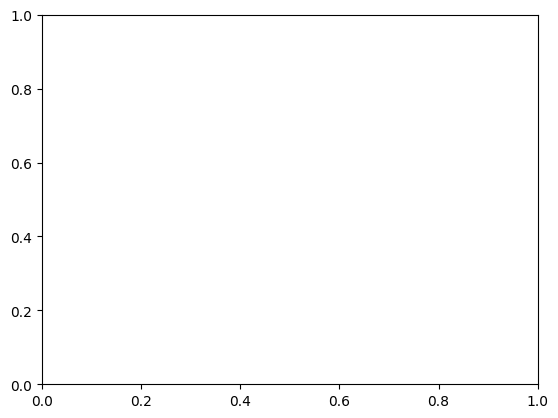

In [142]:
import matplotlib.pyplot as plt
plt.plot(gamma_grid,loss_vals)
plt.xscale('log')

In [108]:
gamma_grid[jnp.argmin(loss_vals)]

Array(1.35935639, dtype=float64)

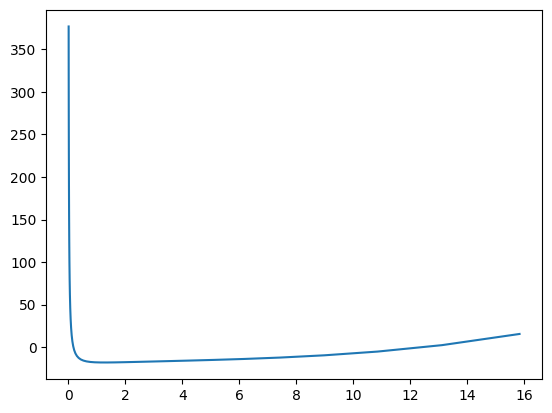

In [107]:
plt.plot(gamma_grid,loss_vals)

In [66]:
from correlation_correction.HamMethods import ham_vanilla
from correlation_correction.CorrFuncs import covariance_matrix
x_init = (10/jnp.min(V))*jnp.ones(len(V))
L = L_vals[0]
V = V_vals[0]
p = p_vals[0]
z = z_vals[0]
ham_vanilla(L,p,z,V,x_init)
covariance_matrix(L,A0,N,M1,p0,z0,x_feas,v,method,OR=True)

ModuleNotFoundError: No module named 'cvxpy'

In [67]:
ham_vanilla(L,p,z,V,x_init)

(Array([586.16742571, 670.37852585, 715.05225617], dtype=float64),
 Array([250.76181119, 154.69778404,  89.39235272], dtype=float64),
 520.7271745092539,
 389.0684876714495)

In [59]:
simulation_results[0][0]

array([0.55763107, 1.17489823, 1.78784963])

In [27]:
df_reg['y']= Y_obs

In [32]:
summary_df = pd.DataFrame({
    'assign':assignment[:,0],
    'is_case':Y_obs
})
summary_df

,assign,is_case
0,0,0.0
1,0,1.0
2,0,1.0
3,0,1.0
4,0,0.0
...,...,...
2995,2,1.0
2996,2,1.0
2997,2,1.0
2998,2,1.0
